In [79]:
import pandas as pd
import numpy as np
import numpy as np
from collections import defaultdict
from dtaidistance import dtw
from src.utils import error
from operator import itemgetter
import sys
from time import time
import heapq
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

In [16]:
"""Union Find structure with Path Compression + Merge by Size"""
class DSU:
    def __init__(self, n):
        self.par = np.arange(n)
        self.siz = np.ones(n)
        
    def find(self, x):
        if self.par[x] == x:
            return x
        self.par[x] = self.find(self.par[x])
        return self.par[x]
    
    def same(self, u, v):
        return self.find(u) == self.find(v)

    def merge(self, u, v):
        u = self.find(u)
        v = self.find(v)
        if u == v:
            return
        if self.siz[u] > self.siz[v]:
            u, v = v, u
        self.par[u] = v
        self.siz[v] += self.siz[u]

"""Optimum Path Forest Classifier"""
class OptimumPathForestClassifier:    
    def __init__(self, cost='euclidean-distance'):
        available_cost_functions = {
            'euclidean-distance': lambda x, y: np.linalg.norm(x - y),
            'manhattan-distance': lambda x, y: np.sum(np.abs(x - y)),
            'dtw-distance': lambda x, y: dtw.distance_fast(x, y, window=100, use_pruning=True)
        }
        assert cost in available_cost_functions.keys(),\
            f"Invalid cost function. Should be one of {available_cost_functions.keys()}"
        self.F = available_cost_functions[cost]
    
    def fit(self, X_, Y_):
        n = len(Y_)
        self.X = np.array(X_, copy=True, dtype=float)
        self.label = np.ones(n, dtype=int) * -1
        Y = np.array(Y_, copy=True, dtype=int)
        
        # First of all, builds the graph
        self.adj = defaultdict(list)
        self.edges = []
        for u in range(n):
            self.adj[u] = [(v, self.F(self.X[u], self.X[v])) for v in range(n)]
            self.edges += [(w, u, v) for v, w in self.adj[u]]
        
        # Runs MST (Kruskal) to choose PROTOTYPES (seed vertices)
        self.prototypes = []        
        self.edges.sort()
        dsu = DSU(n)
        for w, u, v in self.edges:
            if not dsu.same(u, v):
                dsu.merge(u, v)
                if Y[u] != Y[v]:
                    self.prototypes += [u, v]
        self.prototypes = np.unique(self.prototypes)
        
        # Run multisourced dijkstra on prototypes to get the cost
        self.cost = np.ones(n) * np.inf
        self.cost[self.prototypes] = 0
        self.label[self.prototypes] = Y[self.prototypes]
        
        pq = [[0., u] for u in self.prototypes]
        heapq.heapify(pq)
        while pq:
            u_w, u = heapq.heappop(pq)
            if self.cost[u] < u_w:
                continue
            for v, w in self.adj[u]:
                if self.cost[v] > max(u_w, w):
                    self.cost[v] = max(u_w, w)
                    self.label[v] = self.label[u]
                    heapq.heappush(pq, [self.cost[v], v])
        self.ordered_nodes = [(u, self.cost[u]) for u in range(n)]
        self.ordered_nodes.sort(key=itemgetter(1))
                    
    def _classify_one_vertex(self, x):
        best_index, best_cost = self.ordered_nodes[0]
        best_cost = max(best_cost, self.F(self.X[best_index], x))
        best_label = self.label[best_index]
        
        for i in range(1, len(self.X)):
            cur_index, cur_cost = self.ordered_nodes[i]
            if cur_cost > best_cost:
                break
            cur_cost = max(cur_cost, self.F(self.X[cur_index], x))
            cur_label = self.label[cur_index]
            if cur_cost < best_cost:
                best_index, best_cost, best_label = cur_index, cur_cost, cur_label
        return best_label
    
    def classify(self, X_):
        X_train = np.array(X_, copy=True)
        return [self._classify_one_vertex(x) for x in X_train]

In [112]:
df_name = 'ChlorineConcentration'
df = pd.read_table(f'data/UCRArchive_2018/{df_name}/{df_name}_TRAIN.tsv', header=None)
df_test = pd.read_table(f'data/UCRArchive_2018/{df_name}/{df_name}_TEST.tsv', header=None)

X, Y = df.iloc[:, 1:], df.iloc[:, 0]
X_test, Y_test = df_test.iloc[:, 1:], df_test.iloc[:, 0]

In [113]:
opf = OptimumPathForestClassifier('euclidean-distance')
opf.fit(X, Y)
preds = opf.classify(X_test)

In [114]:
embedding = MDS(n_components=2)
X_t = embedding.fit_transform(X)
X.shape, X_t.shape

((467, 166), (467, 2))

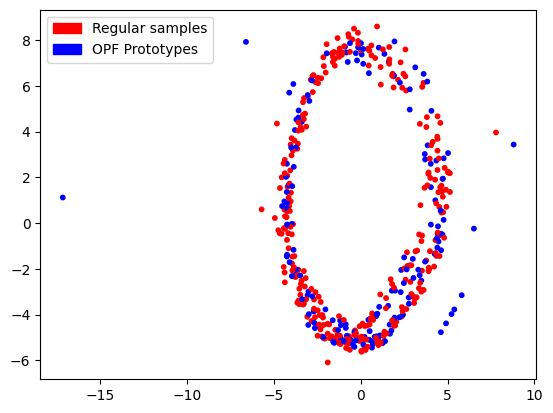

In [119]:
colors = np.array(["blue"] * X_t.shape[0])
colors[opf.prototypes] = "red"
plt.scatter(X_t[:,0], X_t[:,1], color=colors, s=10)
plt.legend(handles=[
    mpatches.Patch(color='red', label='Regular samples'),
    mpatches.Patch(color='blue', label='OPF Prototypes')
])
plt.show()

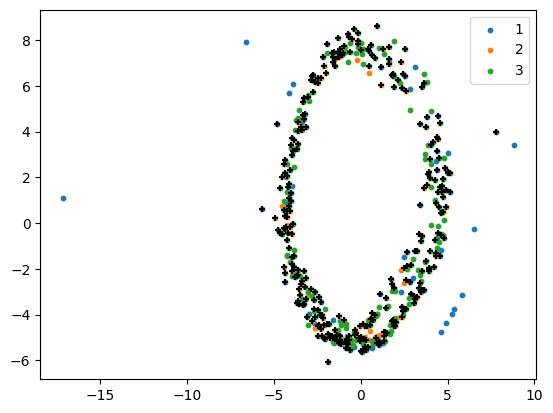

In [117]:
plt.scatter(X_t[Y==1,0], X_t[Y==1,1], s=10)
plt.scatter(X_t[Y==2,0], X_t[Y==2,1], s=10)
plt.scatter(X_t[Y==3,0], X_t[Y==3,1], s=10)
plt.scatter(X_t[opf.prototypes,0], X_t[opf.prototypes,1], s=13, c='black', marker='+')
plt.legend(["1", "2", "3"])
plt.show()